In [1]:
import time

import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from scikeras.wrappers import KerasClassifier

from preprocess import Preprocessing, PATH
from evaluation import get_results

/Users/torokpeter/Documents/tuw/first/machine_learning/machinelearning-tuw/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training MLP...
The model fit took 1.2306 seconds
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10-Fold CV Scores: [0.87122048 0.93593431 0.83429533 0.88461538 0.83333333 0.87160062
 0.84599876 0.80595393 0.81690673 0.87012987]
Average f1_weighted Score: 0.8570
Standard Deviation: 0.0360
              precision    recall  f1-score   support

           1       0.85      0.88      0.87        78
           2       0.88      0.84      0.86        75
           3       1.00      1.00      1.00        42

    accuracy                           0.89       195
   macro avg       0.91      0.91      0.91       195
weighted avg       0.89      0.89      0.89       195



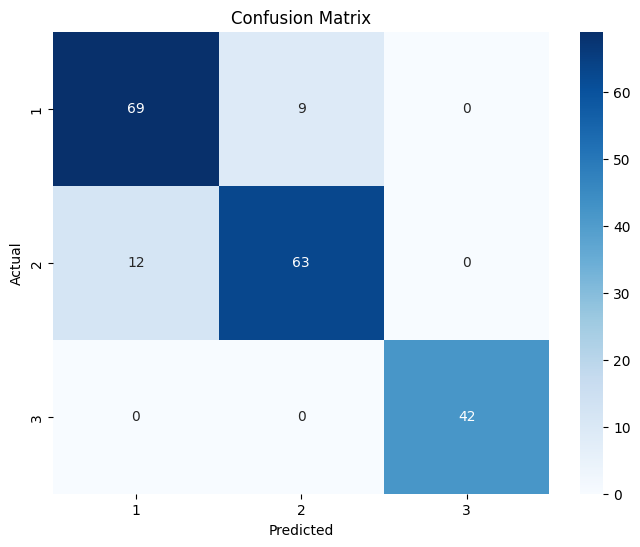

In [2]:
def build_neural_net(dense1=64, dense2=32, dropout=0.3, input_shape=None, num_classes=None):
    """
    Builds a keras MLP with dropout
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(dense1, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(dense2, activation='relu'),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation='softmax') 
    ])
    
    # We use 'sparse_categorical_crossentropy' because our y labels are integers (0, 1, 2 ) after transform
    # not one-hot encoded vectors.
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def neural_net_pipeline(dense1=64, dense2=32, dropout=0.3):
    """
    Runs neural net pipeline

    Loads data, builds and trains MLP, tests metrics
    """
    pp = Preprocessing()
    X_train, X_test, y_train, y_test = pp.pipeline(PATH, split=True, scale=True, encode_labels=True)
    
    nn_model = build_neural_net(input_shape=X_train.shape[1], num_classes=len(pp.labels), dense1=dense1, dense2=dense2, dropout=dropout)
    
    print("Training MLP...")
    t0 = time.time()
    nn_model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.1,
        verbose=0
    )
    t1 = time.time()
    print(f'The model fit took {t1-t0:.4f} seconds')
    y_prob_nn = nn_model.predict(X_test)
    y_pred_nn = np.argmax(y_prob_nn, axis=1)

    keras_model = KerasClassifier(
        model=build_neural_net,
        input_shape=X_train.shape[1],
        num_classes=len(pp.labels),
        epochs=30,
        batch_size=32,
        verbose=0
    )
    validation_scores = cross_val_score(keras_model, X_train, y_train, cv=10, scoring='f1_weighted')
    print(f"10-Fold CV Scores: {validation_scores}")
    print(f"Average f1_weighted Score: {validation_scores.mean():.4f}")
    print(f"Standard Deviation: {validation_scores.std():.4f}")

    get_results(y_test, y_pred_nn, pp.labels)
    return classification_report(y_test, y_pred_nn, output_dict=True)

result = neural_net_pipeline()

When working with neural networks, we could set almost everything, meaning the hyperparameter optimization task could be massive if we'd like. 

For our tests we now test different parameters for the 2 dense layers, how many epochs we train the model, and the dropout

In [3]:
def grid_search_nn(X_train, y_train, input_shape, num_classes):
    
    param_grid = {
        'dropout': [0.2, 0.3],
        'dense1': [32, 64],
        'dense2': [16, 32]
    }
    
    model = KerasClassifier(
        model=build_neural_net,
        input_shape=input_shape,
        num_classes=num_classes,
        epochs=20,
        batch_size=32,
        verbose=0,
        # set default values for parameters we'll search over
        dense1=64,
        dense2=32,
        dropout=0.3
    )

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=10)
    grid_search_result = grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search_result.best_params_}")
    print(f"Best score: {grid_search_result.best_score_:.4f}")
    
    return grid_search_result

pp = Preprocessing()
X_train, X_test, y_train, y_test = pp.pipeline(PATH, split=True, scale=True, encode_labels=True)

results = grid_search_nn(
    X_train=X_train, 
    y_train=y_train,
    input_shape=X_train.shape[1],
    num_classes=len(pp.labels)
)

Best parameters: {'dense1': 32, 'dense2': 16, 'dropout': 0.2}
Best score: 0.8663
